In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [61]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 00-01-04 ~ 21-02-05 입니다
# Yahoo Finanace에서 다운로드 받아 null값을 제거한 데이터를 사용합니다

stock = pd.read_csv('C:\Jupyter_Project\Hanyang_Securities_F.csv')
df = stock.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6300,7100,6300,7000,1619.266357,56800
1,2000-01-05,6700,7100,6610,6700,1549.868774,52100
2,2000-01-06,7000,7000,6250,6300,1457.339844,64900
3,2000-01-07,6350,6600,6300,6370,1473.532349,61800
4,2000-01-10,6610,6700,6300,6500,1503.603882,56100


In [62]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6300,7100,6300,7000,1619.266357,56800
1,2000-01-05,6700,7100,6610,6700,1549.868774,52100
2,2000-01-06,7000,7000,6250,6300,1457.339844,64900
3,2000-01-07,6350,6600,6300,6370,1473.532349,61800
4,2000-01-10,6610,6700,6300,6500,1503.603882,56100
...,...,...,...,...,...,...,...
5181,2021-02-01,9200,9480,9100,9380,9380.000000,81355
5182,2021-02-02,9460,9810,9460,9700,9700.000000,105755
5183,2021-02-03,9850,10200,9800,9990,9990.000000,170966
5184,2021-02-04,10100,10200,9940,10150,10150.000000,133504


In [63]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5181,2021-02-01,9200,9480,9100,9380,9380.0,81355
5182,2021-02-02,9460,9810,9460,9700,9700.0,105755
5183,2021-02-03,9850,10200,9800,9990,9990.0,170966
5184,2021-02-04,10100,10200,9940,10150,10150.0,133504
5185,2021-02-05,10200,10800,10150,10650,10650.0,247224


In [64]:
# OHLC를 Adj OHLC로 바꾸기 위한 비율입니다
# Adj OHLC는 과거의 절대가격을 현재 가격의 시점으로 보기위한 수정된 가격입니다
# 과거 발생한 액면분할과 현금배당을 반영한 Adj Close를 기준으로 조정합니다

ratio = df['Adj Close']/df['Close']
ratio

0       0.231324
1       0.231324
2       0.231324
3       0.231324
4       0.231324
          ...   
5181    1.000000
5182    1.000000
5183    1.000000
5184    1.000000
5185    1.000000
Length: 5186, dtype: float64

In [65]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [66]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [67]:
df.rename(columns={'Adj Open':'Open', 'Adj High':'High', 'Adj Low':'Low', 'Adj Close':'Close'}, inplace=True)

In [68]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,1457.339721,1642.398734,1457.339721,1619.266357,56800
1,1549.868774,1642.398253,1529.049641,1549.868774,52100
2,1619.266493,1619.266493,1445.773655,1457.339844,64900
3,1468.905874,1526.736814,1457.339686,1473.532349,61800
4,1529.049486,1549.868617,1457.339147,1503.603882,56100
...,...,...,...,...,...
5181,9200.000000,9480.000000,9100.000000,9380.000000,81355
5182,9460.000000,9810.000000,9460.000000,9700.000000,105755
5183,9850.000000,10200.000000,9800.000000,9990.000000,170966
5184,10100.000000,10200.000000,9940.000000,10150.000000,133504


In [69]:
# MinMaxScaler 클래스를 사용하여 데이터를 스케일링 합니다.
# MinMaxScaler는 데이터의 최대값이 1, 최소값이 0이 되도록 변환합니다

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

# 정규화가 완료된 데이터들은 pandas dataframe으로 변환합니다
# pandas는 시계열 자료에 대한 다양한 기능을 제공하여 LSTM에서 사용하는 window를 만들때 유용합니다

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.069093  0.078420  0.072692  0.082280  0.020301
1     0.076891  0.078420  0.078924  0.076473  0.018620
2     0.082740  0.076587  0.071686  0.068730  0.023197
3     0.070068  0.069256  0.072692  0.070085  0.022088
4     0.075136  0.071089  0.072692  0.072601  0.020050
...        ...       ...       ...       ...       ...
5181  0.721622  0.699387  0.736878  0.731697  0.029080
5182  0.743534  0.725532  0.768164  0.758474  0.037804
5183  0.776402  0.756432  0.797711  0.782742  0.061119
5184  0.797472  0.756432  0.809878  0.796130  0.047725
5185  0.805899  0.803969  0.828128  0.837970  0.088383

[5186 rows x 5 columns]


In [70]:
# window는 LSTM을 훈련하기 위한 단위로 고정된 사이즈를 가집니다
# window가 12개라면 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값의 예측하게 됩니다
# 테스트 기간은 21일, 따라서 5299-21 : train / 21 : test

window_size = 20
TEST_SIZE = 1037

In [71]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [72]:
test.describe()

,Open,High,Low,Close,Volume
count,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000
mean,0.555879,0.526694,0.567086,0.551764,0.012608
std,0.079533,0.076859,0.080378,0.079329,0.036624
min,0.319620,0.315917,0.326686,0.314971,0.000169
25%,0.502964,0.475662,0.513952,0.498957,0.002769
50%,0.539574,0.509858,0.550341,0.535049,0.005645
75%,0.568782,0.538644,0.580720,0.565572,0.012352
max,0.831182,0.803969,0.828128,0.837970,1.000000


In [73]:
# 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어준다

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [74]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train set : 모델을 학습하는 유일한 dataset
# validation set : 학습이 이미 완료된 모델을 검증하기 위한 dataset(비율 0.2) 
# validation_split : X_train과 y_train에서 일정 비율을 분리하여 검증데이터로 사용
# 훈련 자체에는 반영되지 않고 훈련 과정을 지켜보기 위한 용도로 사용된다
# train_test_split 함수는 전체 데이터 셋 배열을 받아서 랜덤하게 훈련/테스트 데이터 셋으로 분리해주는 함수입니다

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.25)

x_train.shape, x_valid.shape
# ((4206, 20, 4), (1052, 20, 4))

# test dataset : 학습과 검증이 완료된 모델의 성능을 평가하기 위한 dataset
x_test = test[feature_cols]
y_test = test[label_cols]

x_test.shape, y_test.shape
#     (21, 4),          (21, 1)  

((1037, 4), (1037, 1))

In [75]:
x_test, y_test = make_dataset(x_test, y_test, 20)

x_test.shape, y_test.shape
# (21-20, 20, 4),     (21-20, 1)

((1017, 20, 4), (1017, 1))

In [76]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape

((3096, 20, 4), (1033, 20, 4), (3096, 1), (1033, 1), (1017, 20, 4), (1017, 1))

In [77]:
# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df_scaled),2),
                                                       round(len(y_valid)/len(df_scaled),2),
                                                       round(len(y_test)/len(df_scaled),2)))

train: 0.6% | validation: 0.2% | test 0.2%


In [78]:
x_test.shape[0]

1017

>> 데이터 비율을 지정하는 방법에 대한 규칙은 없다. 다만 모델에 제공하는 데이터를 제한하면 학습할 수 있는 내용이 제한된다. 그러나 테스트 세트가 너무 작으면 모델 성능에 대한 정확한 추정치를 제공하지 않는다. 교차 검증을 통해 이 상황을 쉽게 처리할 수 있다

In [79]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

# LSTM은 RNN 알고리즘의 특별한 한 종류입니다. 
# LSTM은 긴 의존기간을 필요로 하는 데이터를 학습하는데 효과적인 모델입니다
# 이 모델은 add함수를 사용하여 레이어들을 선형으로 쌓는 Sequential Model 입니다
# 16 메모리 셀을 가진 LSTM 레이어 하나와 Dense 레이어 하나(output)을 사용합니다
# input_shape는 input이 어떤 모양으로 들어올지에 대한 정보입니다. 데이터 개수는 중요하지 않기에 window_size와 feature만 알려주면 된다
# train_feature.shape[1] = window_size / train_feature.shape[2] = ['Open', 'High', 'Low', 'Volume']
# 예측하고자 하는 target 개수가 하나이므로 Dense(1)dl 출력으로 사용됩니다

model = Sequential()
model.add(LSTM(20, 
               input_shape=(x_test.shape[1], x_test.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [80]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 20)                2000      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [81]:
x_test.shape

(1017, 20, 4)

In [82]:
# val_loss가 10회 같을 시 early_stop, batch_size(=K)는 K문제 풀고 답보고 하는 식
# 위에서 모델을 구성한 후 compile 메서드를 호출하여 학습과정을 설정합니다
# optimizer : 훈련 과정을 설정한다
# loss : 최적화 과정에서 최소화될 손실 함수(loss function)을 설정합니다
# metrics : 훈련을 모니터링하기 위해 사용됩니다
# validation_data = 검증 데이터를 사용합니다. 각 에포크마다 정확도도 함께 출력됩니다
# 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증데이터를 학습하지는 않습니다
# 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 overfitting의 신호입니다
# verbose / 0 : 출력 없음 / 1 : 훈련 진행도 보여주는 진행 막대 보여줌 / 2 : 미니 배치마다 손실 정보 출력

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def MPE(y_true, y_pred): 
    return K.mean((y_true - y_pred) / y_true) * 100
    
def MSLE(y_true, y_pred):
    return K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1)

def RMSLE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1))

def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
    
model.compile(loss = RMSE, optimizer='adam', metrics=[soft_acc, 'mse', 'mae', RMSE, 'mape', MPE, MSLE, RMSLE, R2])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=128,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

# score_test를 만들면 테스트가 더이상 테스트가 아니고, 처음부터 모든 데이터에 대해 학습한 것과 같기 때문에 일반화 할 수 없는 모델을 만드는 것과 같다.


score_train = model.evaluate(x_train, y_train, batch_size=128)
score_validation = model.evaluate(x_valid, y_valid, batch_size=128)


Epoch 1/200
25/25 [==============================] - 3s 28ms/step - loss: 0.2670 - soft_acc: 0.8677 - mse: 0.0764 - mae: 0.2159 - RMSE: 0.2667 - mape: 10271.5099 - MPE: -inf - MSLE: 0.0460 - RMSLE: 0.1711 - R2: -0.7152 - val_loss: 0.0723 - val_soft_acc: 0.9497 - val_mse: 0.0053 - val_mae: 0.0619 - val_RMSE: 0.0713 - val_mape: 235.9755 - val_MPE: -222.6949 - val_MSLE: 0.0038 - val_RMSLE: 0.0507 - val_R2: 0.8868

Epoch 00001: val_loss improved from inf to 0.07234, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0664 - soft_acc: 0.9270 - mse: 0.0046 - mae: 0.0569 - RMSE: 0.0663 - mape: 5939.5711 - MPE: -inf - MSLE: 0.0031 - RMSLE: 0.0457 - R2: 0.8967 - val_loss: 0.0407 - val_soft_acc: 0.9783 - val_mse: 0.0017 - val_mae: 0.0295 - val_RMSE: 0.0397 - val_mape: 128.3251 - val_MPE: -119.7172 - val_MSLE: 0.0011 - val_RMSLE: 0.0245 - val_R2: 0.9647

Epoch 00002: val_lo


Epoch 00015: val_loss improved from 0.01824 to 0.01794, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 16/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0193 - soft_acc: 0.9780 - mse: 3.8026e-04 - mae: 0.0115 - RMSE: 0.0193 - mape: 484.1939 - MPE: -inf - MSLE: 1.6635e-04 - RMSLE: 0.0083 - R2: 0.9911 - val_loss: 0.0178 - val_soft_acc: 0.9792 - val_mse: 3.2675e-04 - val_mae: 0.0098 - val_RMSE: 0.0199 - val_mape: 9.9099 - val_MPE: -3.6819 - val_MSLE: 1.4504e-04 - val_RMSLE: 0.0071 - val_R2: 0.9911

Epoch 00016: val_loss improved from 0.01794 to 0.01783, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 17/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0178 - soft_acc: 0.9839 - mse: 3.3648e-04 - mae: 0.0102 - RMSE: 0.0178 - mape: 726.7397 - MPE: -inf - MSLE: 1.4595e-04 - RMSLE: 0.0073 - R2: 0.9922 - val_loss: 0.0178 - val_soft_acc: 


Epoch 00031: val_loss did not improve from 0.01689
Epoch 32/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0187 - soft_acc: 0.9813 - mse: 3.5924e-04 - mae: 0.0110 - RMSE: 0.0187 - mape: 453.8451 - MPE: -inf - MSLE: 1.5064e-04 - RMSLE: 0.0078 - R2: 0.9921 - val_loss: 0.0205 - val_soft_acc: 0.9757 - val_mse: 4.2980e-04 - val_mae: 0.0144 - val_RMSE: 0.0229 - val_mape: 8.5164 - val_MPE: 3.5738 - val_MSLE: 1.9769e-04 - val_RMSLE: 0.0104 - val_R2: 0.9881

Epoch 00032: val_loss did not improve from 0.01689
Epoch 33/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0186 - soft_acc: 0.9784 - mse: 3.5962e-04 - mae: 0.0119 - RMSE: 0.0186 - mape: 86.1712 - MPE: -inf - MSLE: 1.5964e-04 - RMSLE: 0.0086 - R2: 0.9916 - val_loss: 0.0170 - val_soft_acc: 0.9783 - val_mse: 2.9493e-04 - val_mae: 0.0095 - val_RMSE: 0.0186 - val_mape: 6.8436 - val_MPE: -0.2619 - val_MSLE: 1.3096e-04 - val_RMSLE: 0.0068 - val_R2: 0.9922

Epoch 00033: val_loss did not improve from 0.01689


25/25 [==============================] - 0s 9ms/step - loss: 0.0162 - soft_acc: 0.9808 - mse: 2.7432e-04 - mae: 0.0093 - RMSE: 0.0163 - mape: 4192.9965 - MPE: -inf - MSLE: 1.1767e-04 - RMSLE: 0.0067 - R2: 0.9936 - val_loss: 0.0169 - val_soft_acc: 0.9818 - val_mse: 2.9564e-04 - val_mae: 0.0106 - val_RMSE: 0.0192 - val_mape: 7.5333 - val_MPE: 0.8400 - val_MSLE: 1.3343e-04 - val_RMSLE: 0.0077 - val_R2: 0.9916

Epoch 00048: val_loss did not improve from 0.01589
Epoch 49/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0169 - soft_acc: 0.9759 - mse: 2.9821e-04 - mae: 0.0100 - RMSE: 0.0169 - mape: 2973.3450 - MPE: -inf - MSLE: 1.2918e-04 - RMSLE: 0.0072 - R2: 0.9930 - val_loss: 0.0156 - val_soft_acc: 0.9835 - val_mse: 2.5041e-04 - val_mae: 0.0084 - val_RMSE: 0.0175 - val_mape: 8.2528 - val_MPE: -3.5853 - val_MSLE: 1.1021e-04 - val_RMSLE: 0.0060 - val_R2: 0.9930

Epoch 00049: val_loss improved from 0.01589 to 0.01557, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Ass

25/25 [==============================] - 0s 9ms/step - loss: 0.0141 - soft_acc: 0.9872 - mse: 2.1269e-04 - mae: 0.0083 - RMSE: 0.0141 - mape: 322.0480 - MPE: -inf - MSLE: 9.3549e-05 - RMSLE: 0.0060 - R2: 0.9951 - val_loss: 0.0152 - val_soft_acc: 0.9774 - val_mse: 2.3852e-04 - val_mae: 0.0086 - val_RMSE: 0.0168 - val_mape: 12.4726 - val_MPE: -9.9642 - val_MSLE: 1.0687e-04 - val_RMSLE: 0.0062 - val_R2: 0.9937

Epoch 00064: val_loss did not improve from 0.01494
Epoch 65/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0140 - soft_acc: 0.9857 - mse: 2.0958e-04 - mae: 0.0080 - RMSE: 0.0140 - mape: 1739.1669 - MPE: -inf - MSLE: 9.1879e-05 - RMSLE: 0.0058 - R2: 0.9951 - val_loss: 0.0151 - val_soft_acc: 0.9835 - val_mse: 2.3471e-04 - val_mae: 0.0085 - val_RMSE: 0.0168 - val_mape: 7.2721 - val_MPE: 4.1280 - val_MSLE: 1.0583e-04 - val_RMSLE: 0.0062 - val_R2: 0.9937

Epoch 00065: val_loss did not improve from 0.01494
Epoch 66/200
25/25 [==============================] - 0s 8ms/s


Epoch 00079: val_loss improved from 0.01459 to 0.01453, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 80/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0150 - soft_acc: 0.9877 - mse: 2.3543e-04 - mae: 0.0086 - RMSE: 0.0150 - mape: 187.6014 - MPE: -inf - MSLE: 1.0090e-04 - RMSLE: 0.0062 - R2: 0.9947 - val_loss: 0.0173 - val_soft_acc: 0.9731 - val_mse: 3.0475e-04 - val_mae: 0.0104 - val_RMSE: 0.0178 - val_mape: 11.9642 - val_MPE: -10.0063 - val_MSLE: 1.3162e-04 - val_RMSLE: 0.0074 - val_R2: 0.9931

Epoch 00080: val_loss did not improve from 0.01453
Epoch 81/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0155 - soft_acc: 0.9789 - mse: 2.4786e-04 - mae: 0.0096 - RMSE: 0.0155 - mape: 784.7579 - MPE: -inf - MSLE: 1.1147e-04 - RMSLE: 0.0069 - R2: 0.9942 - val_loss: 0.0143 - val_soft_acc: 0.9800 - val_mse: 2.1266e-04 - val_mae: 0.0078 - val_RMSE: 0.0159 - val_mape: 10.3321 - val_MPE: -7.4698

25/25 [==============================] - 0s 9ms/step - loss: 0.0146 - soft_acc: 0.9872 - mse: 2.1675e-04 - mae: 0.0079 - RMSE: 0.0146 - mape: 1347.1049 - MPE: -inf - MSLE: 9.2956e-05 - RMSLE: 0.0056 - R2: 0.9949 - val_loss: 0.0141 - val_soft_acc: 0.9835 - val_mse: 2.0392e-04 - val_mae: 0.0075 - val_RMSE: 0.0152 - val_mape: 5.6530 - val_MPE: -0.5871 - val_MSLE: 8.9702e-05 - val_RMSLE: 0.0054 - val_R2: 0.9949

Epoch 00096: val_loss improved from 0.01412 to 0.01406, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 97/200
25/25 [==============================] - 0s 10ms/step - loss: 0.0147 - soft_acc: 0.9865 - mse: 2.2609e-04 - mae: 0.0082 - RMSE: 0.0147 - mape: 453.6084 - MPE: -inf - MSLE: 9.8982e-05 - RMSLE: 0.0059 - R2: 0.9949 - val_loss: 0.0139 - val_soft_acc: 0.9852 - val_mse: 1.9993e-04 - val_mae: 0.0074 - val_RMSE: 0.0151 - val_mape: 6.6858 - val_MPE: -2.3460 - val_MSLE: 8.8296e-05 - val_RMSLE: 0.0053 - val_R2: 0.9949

Epoch


Epoch 00111: val_loss did not improve from 0.01363
Epoch 112/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0156 - soft_acc: 0.9781 - mse: 2.5256e-04 - mae: 0.0095 - RMSE: 0.0156 - mape: 766.6860 - MPE: -inf - MSLE: 1.0904e-04 - RMSLE: 0.0069 - R2: 0.9940 - val_loss: 0.0136 - val_soft_acc: 0.9852 - val_mse: 1.9082e-04 - val_mae: 0.0072 - val_RMSE: 0.0145 - val_mape: 6.3538 - val_MPE: -1.8123 - val_MSLE: 8.4726e-05 - val_RMSLE: 0.0052 - val_R2: 0.9954

Epoch 00112: val_loss improved from 0.01363 to 0.01360, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 113/200
25/25 [==============================] - 0s 9ms/step - loss: 0.0140 - soft_acc: 0.9896 - mse: 2.0350e-04 - mae: 0.0079 - RMSE: 0.0140 - mape: 1539.9091 - MPE: -inf - MSLE: 8.6808e-05 - RMSLE: 0.0056 - R2: 0.9953 - val_loss: 0.0145 - val_soft_acc: 0.9774 - val_mse: 2.1450e-04 - val_mae: 0.0083 - val_RMSE: 0.0150 - val_mape: 9.2007 - val_MPE: -6.7773 

In [90]:
pred = model.predict(x_test)
pred.shape

(1017, 1)

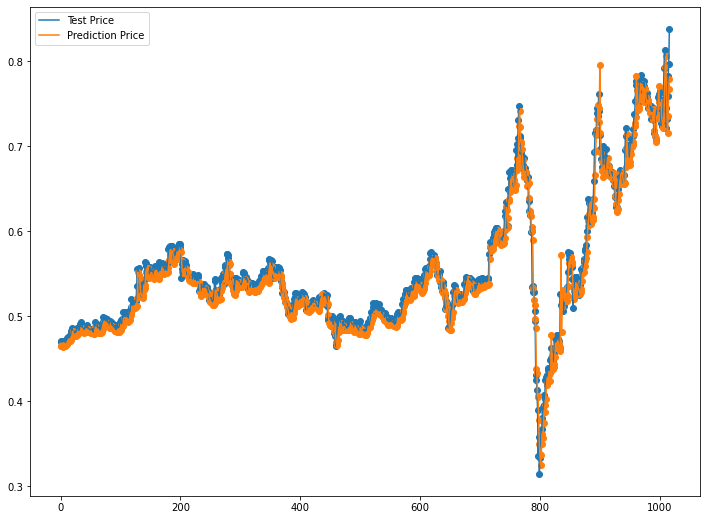

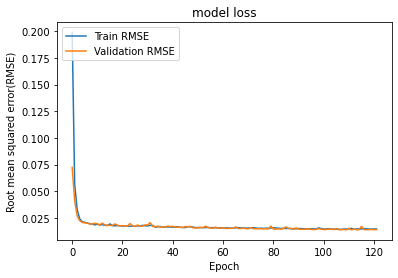

In [84]:
pred = model.predict(x_test)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test), label='Test Price')
plt.plot(pred, label='Prediction Price')
x_values = list(range(1017))
plt.scatter(x_values, np.asarray(y_test))
plt.scatter(x_values, pred)
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Root mean squared error(RMSE)')
plt.xlabel('Epoch')
plt.legend(['Train RMSE', 'Validation RMSE'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Prices vs Predicted price Index')

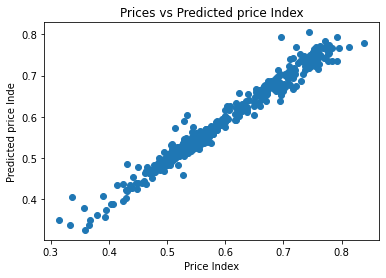

In [85]:
# 원래값과 예측 값이 일치하면 직선에 가깝게 분포가 된다

%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(np.asarray(y_test), pred)
plt.xlabel("Price Index")
plt.ylabel("Predicted price Inde")
plt.title("Prices vs Predicted price Index")

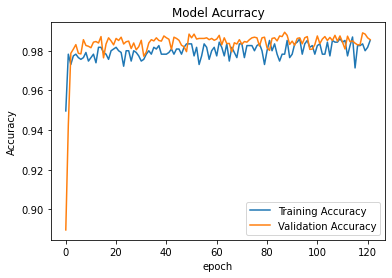

In [86]:
plt.plot(history.history['val_soft_acc'])
plt.plot(history.history['soft_acc'])
plt.title('Model Acurracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [87]:
accuracy_train = 100*score_train[1]
accuracy_validation = 100*score_validation[1]

print('train accuracy: %.4f%%' % accuracy_train)
print('validation accuracy: %.4f%%' % accuracy_validation)

train accuracy: 98.7188%
validation accuracy: 98.5243%


>> R2_Score가 train data에서 계산되면 모델이 샘플 내 분산을 얼마나 설명하는지에 대해 알려주고 test data에서 계산되면 모델의 예측품질에 대해 알려준다. 기계 학습 세계에서는 검증과 테스트 정확도를 모두 제시하는 것이 매우 일반적이지만 가장 중요한 것은 테스트 정확도입니다. 그러나 한 쪽에서 낮은 R2 점수를 받고 그렇지 않다면 뭔가 꺼진 것입니다. R2 test << R2training이면 모델이 잘 일반화되지 않았음을 나타낸다. 예를들어 테스트 세트에 future 데이타 만 포함되어 있으면 모델이 잘 외삽되지 않는 것처럼 보입니다. 결론적으로 당신은 그것을 비교해야 합니다. 그러나 대부분의 경우 가장 관심이 있는 테스트 세트 결과입니다

In [88]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

Y = np.asarray(y_test)
Y_hat = pred

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred-y_true)**2))

def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

def root_mean_squared_log_error(y_true, y_pred): 
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

print('R2_Score')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[9], score_validation[9], r2_score(Y, Y_hat)))

print('Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[2], score_validation[2], MSE(Y, Y_hat)))

print('Mean Absolute Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[3], score_validation[3], MAE(Y, Y_hat)))

print('Root Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[4], score_validation[3], RMSE(Y, Y_hat)))

print('Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[7], score_validation[7], mean_squared_log_error(Y, Y_hat)))

print('Root Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[8], score_validation[8], root_mean_squared_log_error(Y, Y_hat)))

print('Mean Absolute Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[5], score_validation[3], MAPE(Y, Y_hat)))

print('Mean Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[6], score_validation[3], MPE(Y, Y_hat)))


R2_Score
----------------------------------------
train error: 0.9949146509170532 |
valid error: 0.9951903820037842 |
test error : 0.9720966790266582

Mean Squared Error
----------------------------------------
train error: 0.00022053539578337222 |
valid error: 0.0001990355522138998 |
test error : 0.00017508708848726595

Mean Absolute Error
----------------------------------------
train error: 0.008375909179449081 |
valid error: 0.007982892915606499 |
test error : 0.008934732910934664

Root Mean Squared Error
----------------------------------------
train error: 0.014350206591188908 |
valid error: 0.007982892915606499 |
test error : 0.013232047781324929

Mean Squared Logarithmic Error
----------------------------------------
train error: 9.467703057453036e-05 |
valid error: 8.992088260129094e-05 |
test error : 6.94518171870125e-05

Root Mean Squared Logarithmic Error
----------------------------------------
train error: 0.006016233004629612 |
valid error: 0.005799406673759222 |
test er

In [28]:
# count : 개수, std : 표준편차

test[label_cols].describe()

,Close
count,1037.000000
mean,0.551764
std,0.079329
min,0.314971
25%,0.498957
50%,0.535049
75%,0.565572
max,0.837970
